Shrugs_segment_7_start_15m07s730ms_pose.json: Reps=8, Valid frames=509/509, Signal variance=19.3957, L_conf=1.00, R_conf=1.00


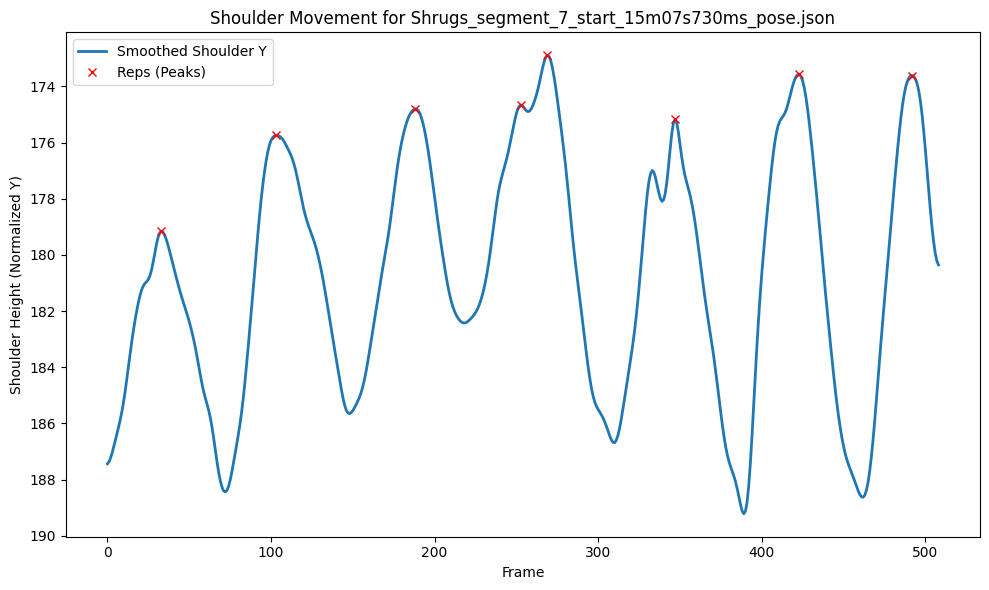

Results saved to C:\Users\bdsid\OneDrive\Desktop\Dune Tech\Rep Counting\Data\Test_Bhaskar_Sir\Shrugs\Json\rep_counts_shrugs_from_json.csv
                                      File_Name  Rep_Count
0  Shrugs_segment_7_start_15m07s730ms_pose.json          8


In [1]:
import json
import os
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

def interpolate_signal(signal, valid_idx, all_idx):
    valid_signal = signal[valid_idx]
    interp_signal = np.interp(all_idx, valid_idx, valid_signal)
    return interp_signal

def count_shrug_reps_from_json(json_path, confidence_threshold=0.6, visualize=False, frame_rate=30):
    with open(json_path, 'r') as f:
        frames = json.load(f)
    
    left_shoulder_ys = []
    right_shoulder_ys = []
    combined_ys = []
    left_confidences = []
    right_confidences = []
    frame_indices = []

    for frame_count, frame_data in enumerate(frames):
        landmarks = frame_data.get("landmarks", [])
        
        # Find left and right shoulder landmarks by name
        left_shoulder = next((lm for lm in landmarks if lm["name"] == "left_shoulder"), None)
        right_shoulder = next((lm for lm in landmarks if lm["name"] == "right_shoulder"), None)
        
        if left_shoulder is None or right_shoulder is None:
            # No shoulder data this frame, append nan and zero confidence
            left_shoulder_ys.append(np.nan)
            right_shoulder_ys.append(np.nan)
            left_confidences.append(0)
            right_confidences.append(0)
            combined_ys.append(np.nan)
            frame_indices.append(frame_count)
            continue
        
        left_conf = left_shoulder.get("conf", 0)
        right_conf = right_shoulder.get("conf", 0)
        
        if left_conf > confidence_threshold:
            left_shoulder_ys.append(left_shoulder["y"])
        else:
            left_shoulder_ys.append(np.nan)
        left_confidences.append(left_conf)
        
        if right_conf > confidence_threshold:
            right_shoulder_ys.append(right_shoulder["y"])
        else:
            right_shoulder_ys.append(np.nan)
        right_confidences.append(right_conf)
        
        if left_conf > confidence_threshold and right_conf > confidence_threshold:
            combined_y = (left_shoulder["y"] + right_shoulder["y"]) / 2
        elif left_conf > confidence_threshold:
            combined_y = left_shoulder["y"]
        elif right_conf > confidence_threshold:
            combined_y = right_shoulder["y"]
        else:
            combined_y = np.nan
        combined_ys.append(combined_y)
        frame_indices.append(frame_count)
    
    if not combined_ys:
        print(f"No valid keypoints detected for {os.path.basename(json_path)}")
        return 0
    
    combined_ys = np.array(combined_ys)
    frame_indices = np.array(frame_indices)
    valid_idx = np.where(~np.isnan(combined_ys))[0]
    
    if len(valid_idx) >= 2:
        combined_ys = interpolate_signal(combined_ys, valid_idx, frame_indices)
    
    smoothed_ys = gaussian_filter1d(combined_ys, sigma=3)
    
    distance = int(frame_rate * 0.5)  # half second minimum distance between reps
    prominence = 0.005
    peaks, _ = find_peaks(-smoothed_ys, distance=distance, prominence=prominence)
    rep_count = len(peaks)
    
    signal_var = np.var(smoothed_ys[~np.isnan(smoothed_ys)])
    print(f"{os.path.basename(json_path)}: Reps={rep_count}, Valid frames={len(valid_idx)}/{len(frames)}, "
          f"Signal variance={signal_var:.4f}, L_conf={np.mean(left_confidences):.2f}, R_conf={np.mean(right_confidences):.2f}")
    
    if visualize:
        plt.figure(figsize=(10, 6))
        plt.plot(smoothed_ys, label="Smoothed Shoulder Y", linewidth=2)
        plt.plot(peaks, smoothed_ys[peaks], "rx", label="Reps (Peaks)")
        plt.gca().invert_yaxis()
        plt.title(f"Shoulder Movement for {os.path.basename(json_path)}")
        plt.xlabel("Frame")
        plt.ylabel("Shoulder Height (Normalized Y)")
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    return rep_count

def process_shrug_jsons(directory_path, visualize=False, frame_rate=30):
    results = []
    json_files = [f for f in os.listdir(directory_path) if f.lower().endswith('.json')]
    
    for json_file in json_files:
        json_path = os.path.join(directory_path, json_file)
        try:
            rep_count = count_shrug_reps_from_json(json_path, visualize=visualize, frame_rate=frame_rate)
            results.append({'File_Name': json_file, 'Rep_Count': rep_count})
        except Exception as e:
            print(f"Error processing {json_file}: {e}")
            results.append({'File_Name': json_file, 'Rep_Count': 0})
    
    df = pd.DataFrame(results)
    output_csv = os.path.join(directory_path, 'rep_counts_shrugs_from_json.csv')
    df.to_csv(output_csv, index=False)
    print(f"Results saved to {output_csv}")
    return df

# Example usage:
if __name__ == "__main__":
    json_dir = r"C:\Users\bdsid\OneDrive\Desktop\Dune Tech\Rep Counting\Data\Test_Bhaskar_Sir\Shrugs\Json"  # Folder with JSON files
    visualize_flag = True
    results_df = process_shrug_jsons(json_dir, visualize=visualize_flag)
    print(results_df)
